In [ ]:
# !pip install -U textblob

In [7]:
# For EDA now, will add more libraries as we progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from textblob import TextBlob

# Set nice style for plots
sns.set_theme(style='darkgrid')
sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.set_context("paper")
import json



# 1. Read Data

Our data was taken from this database of [Google Local Data 2021](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/#subsets). We previously used a smaller dataset of Google Restaurant reviews available [here](https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews), with only 1100 reviews, but as per our TF's recommendation, we will be using this larger dataset with over 10m reviews for Massachusetts alone. To speed up our EDA, we will be using a sample of 100,000 reviews.

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Our main dataset, stored in the `df` variable, contains 100,000 reviews. Our columns of interest are `rating`, which is the rating given by the user, `text`, which is the review text, and `gmap_id`, which is the Google Maps ID of the business. 

We also have a metadata dataset, stored in the `df_meta` variable, which contains information about each business in Massachusetts. The columns of interest are `gmap_id`, allowing us to join this dataset with the main one, `name`, which is the name of the business, and `description`, which is a brief description of the business. There is also a variable `category` that organizes the businesses into sectors such as non-profits, gyms, restaurants, etc. 

In [8]:
# Load the data
# Convert to dataframe
data_list = []
with open('data/review-Massachusetts.json', 'r') as f:
    for line in f:
        try:
            json_obj = json.loads(line)
            data_list.append(json_obj)
        except json.JSONDecodeError:
            print(f"Error decoding the following JSON line: {line}")

df = pd.DataFrame(data_list)

In [9]:
# Examine df
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447007 entries, 0 to 10447006
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   name     object 
 2   time     int64  
 3   rating   float64
 4   text     object 
 5   pics     object 
 6   resp     object 
 7   gmap_id  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 637.6+ MB
None
                 user_id                 name           time  rating  \
0  108990132658983842962         Sherri Mayne  1559246854759     5.0   
1  100425369457528701350       Adam Goodspeed  1557586283214     5.0   
2  118197855649932344021  Christopher Sheehan  1568756947956     4.0   
3  106341493635432341037       Katie Sullivan  1627234799114     5.0   
4  102472657465934208615   Victoria Henderson  1619237055452     5.0   

                                                text  pics  resp  \
0  I love the people that live there, they ate th...  None  None   
1  Stop parking in the resid

In [10]:
# Also load the whole meta-Massachusetts.json file. This contains metadata about the businesses, 
# since the reviews only contain the business id.
with open('data/meta-Massachusetts.json', 'r') as f:
    data_meta = f.readlines()

data_meta_str = "[" + ','.join(data_meta) + "]"
df_meta = pd.read_json(StringIO(data_meta_str))

# Filter dataframe so that it only contains restaurants
df_meta = df_meta[df_meta['category'].apply(lambda x: isinstance(x, list) and any('restaurant' in category.lower() for category in x) if x is not None else False)]

In [11]:
# Examine df
print(df_meta.info())
print(df_meta.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16079 entries, 14 to 92514
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16079 non-null  object 
 1   address           16055 non-null  object 
 2   gmap_id           16079 non-null  object 
 3   description       9341 non-null   object 
 4   latitude          16079 non-null  float64
 5   longitude         16079 non-null  float64
 6   category          16079 non-null  object 
 7   avg_rating        16079 non-null  float64
 8   num_of_reviews    16079 non-null  int64  
 9   price             11987 non-null  object 
 10  hours             15127 non-null  object 
 11  MISC              15994 non-null  object 
 12  state             11728 non-null  object 
 13  relative_results  15090 non-null  object 
 14  url               16079 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.0+ MB
None
                            

In [12]:
# Merging the dataframes on 'gmap_id'
# 'inner' will only include rows that have matching 'gmap_id' in both dataframes
df_combined = pd.merge(df, df_meta, on='gmap_id', how='inner')

In [13]:
# Examine the combined dataframe
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4182567 entries, 0 to 4182566
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   name_x            object 
 2   time              int64  
 3   rating            float64
 4   text              object 
 5   pics              object 
 6   resp              object 
 7   gmap_id           object 
 8   name_y            object 
 9   address           object 
 10  description       object 
 11  latitude          float64
 12  longitude         float64
 13  category          object 
 14  avg_rating        float64
 15  num_of_reviews    int64  
 16  price             object 
 17  hours             object 
 18  MISC              object 
 19  state             object 
 20  relative_results  object 
 21  url               object 
dtypes: float64(4), int64(2), object(16)
memory usage: 702.0+ MB
None
                 user_id      name_x           time  rating  \
0  1053245

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We merged the main dataset and our meta dataset based on `gmap_id` and filtered out the ones of restaurants.

We will clean up the dataframe for our purpose. From below we see that we can probably get rid of these columns: `name_x` (since we don't care about the name of the reviewer, having `user_id` is enough to identify them; `time` (for now we don't care about when the reviewers wrote the reviews); `pics` (we don't care about pictures first, but might use it in the future if time permits); `resp` (most of them are `None`); `gmap_id`(we can identify restaurants based on their names which is easier to understand); `description` (most of them are `None`); `relative_results`; `url`)

We see that there are duplicates in our merged dataset. We will drop the duplicates after we clean up the dataframe to only keep necessary columns.

In [14]:
df_combined.head()

,user_id,name_x,time,rating,text,pics,resp,gmap_id,name_y,address,...,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,105324587117440371682,Jessica,1515819902193,4.0,What a great experience. I tried the chicken t...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
1,105324587117440371682,Jessica,1515819902193,4.0,What a great experience. I tried the chicken t...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
2,111593292201397736581,Jonah Ford,1526075323967,5.0,I've probably driven past this place a million...,None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
3,111593292201397736581,Jonah Ford,1526075323967,5.0,I've probably driven past this place a million...,None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
4,104512515767692446991,Zak Bug,1497983845749,5.0,The food was fantastic. The staff was very fr...,None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...


In [15]:
df_cleaned = df_combined.drop_duplicates(subset=['user_id', 'gmap_id'])

columns_to_drop = ['name_x', 'time', 'pics', 'resp', 'description', 'relative_results', 'url']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Drop duplicates based on `user_id` and `gmap_id` to ensure unique reviews per user per restaurant

df_cleaned.head()

,user_id,rating,text,gmap_id,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state
0,105324587117440371682,4.0,What a great experience. I tried the chicken t...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
2,111593292201397736581,5.0,I've probably driven past this place a million...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
4,104512515767692446991,5.0,The food was fantastic. The staff was very fr...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
6,108597457197204926945,5.0,"The owner, T, is a wonderful man. Super friend...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
8,118226309970656279914,5.0,Just stopped in for a couple of grilled chicke...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed


In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4135196 entries, 0 to 4182566
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   rating          float64
 2   text            object 
 3   gmap_id         object 
 4   name_y          object 
 5   address         object 
 6   latitude        float64
 7   longitude       float64
 8   category        object 
 9   avg_rating      float64
 10  num_of_reviews  int64  
 11  price           object 
 12  hours           object 
 13  MISC            object 
 14  state           object 
dtypes: float64(4), int64(1), object(10)
memory usage: 504.8+ MB


<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The `MISC` column contains dictionaries with useful information. We decided to further process this column and extract the attributes out as new columns of our dataframe.

In [17]:
print(df_cleaned.loc[0, 'MISC'])

{'Service options': ['Takeout', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food', 'Late-night food', 'Vegetarian options'], 'Dining options': ['Lunch', 'Dinner', 'Dessert'], 'Payments': ['Debit cards']}


In [18]:
# First, ensure all entries in 'MISC' are dictionaries; replace None with empty dictionaries
df_cleaned['MISC'] = df_cleaned['MISC'].apply(lambda x: x if isinstance(x, dict) else {})

# Convert the 'MISC' column to a DataFrame where each key in the dictionary becomes a column
misc_expanded = pd.DataFrame(df_cleaned['MISC'].tolist())

In [19]:
# Join the expanded 'MISC' DataFrame with the original 'df_cleaned', excluding the 'MISC' column
df_expanded = pd.concat([df_cleaned.drop(columns=['MISC']), misc_expanded], axis=1)

In [20]:
df_expanded.head()

,user_id,rating,text,gmap_id,name_y,address,latitude,longitude,category,avg_rating,...,Payments,Highlights,Popular for,Amenities,Atmosphere,Health & safety,Crowd,Planning,From the business,Health and safety
0,105324587117440371682,4.0,What a great experience. I tried the chicken t...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,111593292201397736581,5.0,I've probably driven past this place a million...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104512515767692446991,5.0,The food was fantastic. The staff was very fr...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,108597457197204926945,5.0,"The owner, T, is a wonderful man. Super friend...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,118226309970656279914,5.0,Just stopped in for a couple of grilled chicke...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4182567 entries, 0 to 3957456
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            object 
 1   rating             float64
 2   text               object 
 3   gmap_id            object 
 4   name_y             object 
 5   address            object 
 6   latitude           float64
 7   longitude          float64
 8   category           object 
 9   avg_rating         float64
 10  num_of_reviews     float64
 11  price              object 
 12  hours              object 
 13  state              object 
 14  Service options    object 
 15  Accessibility      object 
 16  Offerings          object 
 17  Dining options     object 
 18  Payments           object 
 19  Highlights         object 
 20  Popular for        object 
 21  Amenities          object 
 22  Atmosphere         object 
 23  Health & safety    object 
 24  Crowd              object 
 25  Planning           obje

In [22]:
columns_of_interest = [
    "Service options", "Accessibility", "Offerings", "Dining options",
    "Payments", "Highlights", "Popular for", "Amenities",
    "Atmosphere", "Health & safety", "Crowd", "Planning",
    "From the business", "Health and safety"
]

# Initialize a dictionary to hold the unique values for each column
unique_values = {}

# Iterate over each column of interest
for column in columns_of_interest:
    # Extract the column's data
    column_data = df_expanded[column]
    
    # Since the data might contain lists, we need to flatten these into a single list before finding unique values
    # We'll use a set to automatically keep only unique items
    flattened_set = set()
    for item in column_data.dropna():  # Drop NA values to avoid errors
        if isinstance(item, list):  # Check if the item is a list
            flattened_set.update(item)  # Add all items in the list to the set
        else:
            flattened_set.add(item)  # Add the item itself if it's not a list
    
    # Store the unique values for this column in our dictionary
    unique_values[column] = list(flattened_set)  # Convert the set back to a list for readability

# Or, to print the unique values for all columns of interest:
for column, values in unique_values.items():
    print(f"{column}: {values}\n")

Service options: ['Dine-in', 'Online appointments', 'Curbside pickup', 'Outdoor seating', 'In-store shopping', 'In-store pickup', 'No-contact delivery', 'Takeout', 'Drive-through', 'Takeaway', 'Same-day delivery', 'Delivery', 'In-store pick-up']

Accessibility: ['Wheelchair accessible entrance', 'Assisted listening devices', 'Wheelchair accessible elevator', 'Wheelchair-accessible car park', 'Wheelchair-accessible lift', 'Wheelchair-accessible seating', 'Wheelchair accessible seating', 'Wheelchair-accessible toilet', 'Wheelchair-accessible entrance', 'Wheelchair accessible restroom', 'Wheelchair accessible parking lot', 'Wheelchair rental']

Offerings: ['Comfort food', 'Late-night food', 'Dancing', 'Salad bar', 'Halal food', 'Alcohol', 'Food', 'Happy-hour drinks', 'Coffee', 'Cocktails', "Kids' toys", 'All you can eat', 'Car wash', 'Prepared foods', 'Spirits', 'Service guarantee', 'Wine', 'Ethanol-free gas', 'Organic products', 'Quick bite', 'Braille menu', 'Happy-hour food', 'Happy hou

In [23]:
# Counting NaN values in each column of df_expanded
nan_counts = df_expanded.isna().sum()

# Displaying the count of NaN values per column
print(nan_counts)

user_id                47393
rating                 47393
text                 1939737
gmap_id                47371
name_y                 47371
address                48769
latitude               47371
longitude              47371
category               47371
avg_rating             47371
num_of_reviews         47371
price                 432281
hours                 156138
state                1891583
Service options       148804
Accessibility         412830
Offerings             359532
Dining options        688883
Payments             1605942
Highlights           1359587
Popular for           710651
Amenities             444311
Atmosphere            629354
Health & safety      1675107
Crowd                 666088
Planning             2167329
From the business    4008956
Health and safety    4115234
dtype: int64


<div style="background-color:#3F7FBF; color:white; padding:10px"> 
Since we will focus on reviews, we decided to drop rows with `text` (which is the review column) empty. We will also drop the rows with `rating` empty.

In [24]:
# Drop rows where the 'text' column is NaN
df_expanded_clean = df_expanded.dropna(subset=['text', 'rating'])
df_expanded_clean.isna().sum()

user_id                    0
rating                     0
text                       0
gmap_id                    0
name_y                     0
address                  876
latitude                   0
longitude                  0
category                   0
avg_rating                 0
num_of_reviews             0
price                 228738
hours                  60330
state                 972148
Service options        79738
Accessibility         225759
Offerings             193532
Dining options        373768
Payments              865832
Highlights            733863
Popular for           381437
Amenities             239351
Atmosphere            338583
Health & safety       901797
Crowd                 361852
Planning             1165285
From the business    2150732
Health and safety    2207346
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 
    
Let's further inspect these columns and decide either to drop them or process them.

`Planning`, `From the business`, and `Health and safety` simply just have too many missing values, so we will drop them.

We decided to drop `address` column since we will be able to infer the address based on names of the restaurants and the latitude and longitude.

`state` describes the current states of the restraurants when the dataset authors scraped it. This is not that helpful for our analysis so we will drop this column too.

There are some other variables which are not important for our analysis for now. We will drop them as well and start thinking about how to process the rest (e.g. one-hot encode).

In [25]:
df_expanded_clean['state'].unique()

array(['Permanently closed', None,
       'Closes soon ⋅ 8:30PM ⋅ Opens 11AM Thu', 'Closed ⋅ Opens 7AM Thu',
       'Open ⋅ Closes 10PM', 'Closes soon ⋅ 4PM ⋅ Opens 8AM Thu',
       'Open ⋅ Closes 8PM', 'Open ⋅ Closes 5PM', 'Closed ⋅ Opens 11AM',
       'Closed ⋅ Opens 11:30AM', 'Closed ⋅ Opens 5PM Thu',
       'Open ⋅ Closes 2AM', 'Closed ⋅ Opens 11AM Wed',
       'Closed ⋅ Opens 8AM Wed', 'Closed ⋅ Opens 8:30AM Wed',
       'Closed ⋅ Opens 6AM Wed', 'Closed ⋅ Opens 7:30AM Wed',
       'Open ⋅ Closes 8AM Wed', 'Opens soon ⋅ 9AM',
       'Closed ⋅ Opens 8:30AM', 'Closed ⋅ Opens 4PM Thu',
       'Closed ⋅ Opens 5AM', 'Closed ⋅ Opens 7:15AM',
       'Closes soon ⋅ 9PM ⋅ Opens 10AM Tue', 'Open 24 hours',
       'Open ⋅ Closes 9PM', 'Closed ⋅ Opens 4PM', 'Closed ⋅ Opens 7AM',
       'Closed ⋅ Opens 7:30AM Mon', 'Closed ⋅ Opens 5:30AM Mon',
       'Closed ⋅ Opens 3PM Tue', 'Closed ⋅ Opens 8:30AM Mon',
       'Closed ⋅ Opens 11AM Mon', 'Closed ⋅ Opens 12PM',
       'Closed ⋅ Opens 9AM', 'Clo

In [26]:
df_expanded_clean['price'].unique()

array(['$$', None, '$', '$$$', '$$$$', '₩₩', '₩', '₩₩₩'], dtype=object)

In [27]:
df_expanded_clean

,user_id,rating,text,gmap_id,name_y,address,latitude,longitude,category,avg_rating,...,Payments,Highlights,Popular for,Amenities,Atmosphere,Health & safety,Crowd,Planning,From the business,Health and safety
0,105324587117440371682,4.0,What a great experience. I tried the chicken t...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,111593292201397736581,5.0,I've probably driven past this place a million...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104512515767692446991,5.0,The food was fantastic. The staff was very fr...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,108597457197204926945,5.0,"The owner, T, is a wonderful man. Super friend...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,118226309970656279914,5.0,Just stopped in for a couple of grilled chicke...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182381,115582184004988932581,4.0,Good chowder,0x89e5290944643609:0x6b5cbf7224fe52bc,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182382,110179169236197163158,5.0,The chowder actually is exceptionally delicious.,0x89e5290944643609:0x6b5cbf7224fe52bc,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182383,109898656649575033563,3.0,Chowder...not that good,0x89e5290944643609:0x6b5cbf7224fe52bc,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182384,105223949567719845591,5.0,"(Translated by Google) Nice service, great ser...",0x89e5290944643609:0x6b5cbf7224fe52bc,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# convert hours to string and print unique values
df_expanded_clean['hours'].apply(str).unique()

array(["[['Thursday', '11AM–8PM'], ['Friday', '11AM–10PM'], ['Saturday', '11AM–10PM'], ['Sunday', '4–10PM'], ['Monday', 'Closed'], ['Tuesday', '11AM–8PM'], ['Wednesday', '11AM–8PM']]",
       'None',
       "[['Wednesday', '11AM–8:30PM'], ['Thursday', '11AM–8:30PM'], ['Friday', '11AM–9PM'], ['Saturday', '11AM–9PM'], ['Sunday', '11AM–8:30AM'], ['Monday', '11AM–8:30AM'], ['Tuesday', '11AM–8:30PM']]",
       ...,
       "[['Friday', '11:30AM–8PM'], ['Saturday', '4–8PM'], ['Sunday', '4–8PM'], ['Monday', '11:30AM–8PM'], ['Tuesday', '11:30AM–8PM'], ['Wednesday', '11:30AM–8PM'], ['Thursday', '11:30AM–8PM']]",
       "[['Friday', '7AM–8PM'], ['Saturday', '7AM–8PM'], ['Sunday', '11AM–8PM'], ['Monday', '7AM–8PM'], ['Tuesday', '7AM–8PM'], ['Wednesday', '7AM–8PM'], ['Thursday', '7AM–8PM']]",
       "[['Thursday', 'Closed'], ['Friday', 'Closed'], ['Saturday', 'Closed'], ['Sunday', '3:35–3:36AM'], ['Monday', 'Closed'], ['Tuesday', 'Closed'], ['Wednesday', 'Closed']]"],
      dtype=object)

In [29]:
df_expanded_clean['Service options'].apply(str).unique()

array(["['Takeout', 'Delivery']", "['Delivery']",
       "['No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']",
       "['Delivery', 'Takeout', 'Dine-in']", "['Takeout', 'Dine-in']",
       "['In-store shopping', 'Takeout', 'Dine-in', 'Delivery']",
       "['Takeout', 'Dine-in', 'Delivery']",
       "['Drive-through', 'Takeout', 'Dine-in', 'Delivery']",
       "['Curbside pickup', 'In-store pickup', 'In-store shopping', 'Takeout', 'Dine-in', 'Delivery']",
       "['Outdoor seating', 'Delivery']", "['Delivery', 'Takeout']",
       "['Curbside pickup', 'Takeout', 'Dine-in', 'Delivery']",
       "['In-store shopping']",
       "['Outdoor seating', 'Delivery', 'Takeout', 'Dine-in']",
       "['Dine-in', 'Delivery']",
       "['Curbside pickup', 'No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']",
       'nan', "['In-store shopping', 'Delivery']",
       "['Outdoor seating', 'Curbside pickup', 'No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']",
       "['Curbside pickup',

In [30]:
df_expanded_clean['Accessibility'].apply(str).unique()

array(["['Wheelchair accessible entrance']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible restroom']",
       'nan',
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible restroom', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible restroom']",
       "['Wheelchair accessible seating']",
       "['Wheelchair accessible elevator', 'Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible restroom', 'Wheelchair accessible seating']",
       "['Wheelchair accessible restroom', 'Wheelchair accessible entrance']",
       "['Wheelchair accessible parking lot']",
       "['Wheelchair accessible parking lot', 'Whe

In [31]:
df_expanded_clean['Offerings'].apply(str).unique()

array(["['Comfort food', 'Late-night food', 'Vegetarian options']",
       "['Coffee', 'Comfort food', 'Healthy options', 'Organic dishes', 'Quick bite', 'Vegetarian options']",
       "['Coffee', 'Comfort food', 'Healthy options', 'Quick bite', 'Small plates', 'Vegetarian options']",
       ...,
       '[\'Alcohol\', \'All you can eat\', \'Beer\', \'Braille menu\', \'Cocktails\', \'Coffee\', \'Comfort food\', \'Happy hour drinks\', \'Happy hour food\', \'Hard liquor\', "Kids\' menu", \'Late-night food\', \'Organic dishes\', \'Small plates\', \'Vegetarian options\', \'Wine\']',
       '[\'Alcohol\', \'Coffee\', \'Comfort food\', \'Food\', \'Food at bar\', \'Happy hour food\', "Kids\' menu", \'Late-night food\', \'Quick bite\']',
       '[\'Coffee\', \'Halal food\', \'Healthy options\', "Kids\' menu", \'Late-night food\', \'Quick bite\', \'Vegetarian options\']'],
      dtype=object)

In [32]:
df_expanded_clean['Dining options'].apply(str).unique()

array(["['Lunch', 'Dinner', 'Dessert']",
       "['Breakfast', 'Lunch', 'Dinner', 'Dessert']", "['Dessert']",
       'nan', "['Breakfast', 'Lunch', 'Catering', 'Dessert', 'Seating']",
       "['Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating']",
       "['Breakfast', 'Lunch', 'Dinner', 'Dessert', 'Seating']",
       "['Breakfast']", "['Breakfast', 'Lunch', 'Dessert']",
       "['Breakfast', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering', 'Dessert']",
       "['Breakfast', 'Lunch', 'Dinner']", "['Seating']",
       "['Lunch', 'Dinner', 'Seating']",
       "['Breakfast', 'Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating']",
       "['Lunch', 'Dinner']", "['Breakfast', 'Lunch']",
       "['Breakfast', 'Lunch', 'Dinner', 'Counter service', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering']", "['Lunch', 'Catering']",
       "['Lunch', 'Dinner', 'Dessert', 'Seating']",
       "['Lunch', 'Catering', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering', 'Seating']", "['Dinner']",
    

In [33]:
df_expanded_clean['Payments'].apply(str).unique()

array(["['Debit cards']", 'nan', "['NFC mobile payments']",
       "['Debit cards', 'Credit cards']",
       "['Debit cards', 'NFC mobile payments', 'Credit cards']",
       "['Debit cards', 'NFC mobile payments']",
       "['Checks', 'Debit cards', 'Credit cards']", "['Credit cards']",
       "['Cash-only']", "['Cash-only', 'Debit cards']",
       "['Cash-only', 'Credit cards']",
       "['Cash-only', 'Debit cards', 'Credit cards']",
       "['Cash-only', 'Checks', 'Debit cards', 'NFC mobile payments']",
       "['Cash-only', 'Checks', 'Debit cards', 'Credit cards']",
       "['NFC mobile payments', 'Credit cards']",
       "['Checks', 'Debit cards']",
       "['Checks', 'Debit cards', 'NFC mobile payments']",
       "['Cash-only', 'NFC mobile payments']", "['Checks']",
       "['Cash-only', 'Debit cards', 'NFC mobile payments']",
       "['Checks', 'Debit cards', 'NFC mobile payments', 'Credit cards']",
       "['Cash-only', 'Debit cards', 'NFC mobile payments', 'Credit cards']",
   

In [34]:
df_expanded_clean['Highlights'].apply(str).unique()

array(['nan', "['Great coffee', 'Great dessert', 'Great tea selection']",
       "['Great coffee']", "['Fast service']",
       "['Great beer selection', 'Great cocktails']",
       "['Fast service', 'Great coffee', 'Great tea selection']",
       "['Great coffee', 'Great dessert']", "['Great dessert']",
       "['LGBTQ friendly', 'Transgender safespace']",
       "['Fast service', 'Great coffee']", "['LGBTQ friendly']",
       "['Fireplace', 'Great coffee']",
       "['Great beer selection', 'Great cocktails', 'LGBTQ friendly']",
       "['Great coffee', 'Great wine list']", "['Great cocktails']",
       "['Fireplace', 'Live music']",
       "['Great beer selection', 'Great cocktails', 'Great wine list']",
       "['Live music']", "['Great dessert', 'LGBTQ friendly']",
       "['Great cocktails', 'Live music']",
       "['Fast service', 'Great beer selection', 'Great coffee', 'Great dessert', 'Great wine list']",
       "['Great cocktails', 'Great wine list']",
       "['Great beer se

In [35]:
df_expanded_clean['Popular for'].apply(str).unique()

array(['nan', "['Breakfast', 'Lunch', 'Dinner', 'Solo dining']",
       "['Lunch', 'Dinner', 'Solo dining']",
       "['Breakfast', 'Lunch', 'Solo dining']", "['Solo dining']",
       "['Dinner', 'Solo dining']", "['Lunch', 'Solo dining']",
       "['Breakfast', 'Solo dining']", "['Lunch', 'Dinner']",
       "['Breakfast', 'Dinner', 'Solo dining']",
       "['Breakfast', 'Lunch', 'Dinner']", "['Lunch']",
       "['Breakfast', 'Lunch']", "['Breakfast']", "['Dinner']",
       "['Breakfast', 'Solo dining', 'Good for working on laptop']",
       "['Breakfast', 'Lunch', 'Solo dining', 'Good for working on laptop']",
       "['Breakfast', 'Lunch', 'Dinner', 'Solo dining', 'Good for working on laptop']",
       "['Solo dining', 'Good for working on laptop']",
       "['Lunch', 'Dinner', 'Solo dining', 'Good for working on laptop']",
       "['Lunch', 'Solo dining', 'Good for working on laptop']"],
      dtype=object)

In [36]:
df_expanded_clean['Amenities'].apply(str).unique()

array(['nan', "['Good for kids', 'Restroom']", "['Good for kids']",
       "['Good for kids', 'High chairs', 'Restroom', 'Wi-Fi']",
       "['Gender-neutral restroom', 'Good for kids', 'Restroom']",
       "['Good for kids', 'High chairs']", "['Bar onsite', 'Restroom']",
       "['Good for kids', 'Restroom', 'Wi-Fi']",
       "['Bar onsite', 'Good for kids', 'High chairs']",
       "['Restroom', 'Wi-Fi']", "['Bar onsite']",
       "['Good for kids', 'High chairs', 'Restroom']",
       "['Public restroom', 'Restroom']",
       "['Gender-neutral restroom', 'Good for kids']",
       "['Bar onsite', 'Good for kids']",
       "['Good for kids', 'High chairs', 'Wi-Fi']",
       "['Bar onsite', 'High chairs', 'Restroom', 'Wi-Fi']", "['Wi-Fi']",
       "['Good for kids', 'Wi-Fi']",
       "['Gender-neutral restroom', 'Good for kids', 'High chairs', 'Restroom']",
       "['Bar onsite', 'High chairs']",
       "['Gender-neutral restroom', 'Good for kids', 'High chairs', 'Wi-Fi']",
       "['Bar 

In [37]:
df_expanded_clean['Atmosphere'].apply(str).unique()

array(['nan', "['Casual', 'Cozy']", "['Casual']",
       "['Casual', 'Cozy', 'Quiet']", "['Cozy']",
       "['Casual', 'Romantic']", "['Casual', 'Historic']",
       "['Casual', 'Trending']", "['Trending']", "['Casual', 'Quiet']",
       "['Cozy', 'Romantic']", "['Quiet', 'Romantic']", "['Romantic']",
       "['Cozy', 'Historic']", "['Casual', 'Cozy', 'Romantic']",
       "['Cozy', 'Romantic', 'Upscale']", "['Upscale']",
       "['Romantic', 'Upscale']", "['Casual', 'Cozy', 'Upscale']",
       "['Casual', 'Cozy', 'Historic']", "['Casual', 'Cosy']",
       "['Cosy', 'Romantic', 'Upmarket']",
       "['Cosy', 'Historic', 'Romantic', 'Upmarket']",
       "['Casual', 'Cozy', 'Trending']",
       "['Casual', 'Cozy', 'Romantic', 'Upscale']",
       "['Casual', 'Cosy', 'Historic']", "['Romantic', 'Upmarket']",
       "['Casual', 'Romantic', 'Trending', 'Upscale']",
       "['Casual', 'Cosy', 'Upmarket']",
       "['Cozy', 'Historic', 'Romantic', 'Upscale']",
       "['Casual', 'Cozy', 'Histor

In [38]:
df_expanded_clean['Crowd'].apply(str).unique()

array(['nan', "['Groups', 'Tourists']", "['Family-friendly']",
       "['College students', 'Family-friendly']", "['Groups', 'Locals']",
       "['College students', 'Groups']", "['Groups']",
       "['College students', 'Family-friendly', 'Tourists']",
       "['Tourists']", "['Locals']", "['Family-friendly', 'Groups']",
       "['Family-friendly', 'Tourists']", "['College students']",
       "['Family-friendly', 'Groups', 'Tourists']",
       "['Groups', 'Locals', 'Tourists']",
       "['College students', 'Tourists']",
       "['College students', 'Groups', 'Tourists']",
       "['College students', 'Family-friendly', 'Groups']",
       "['College students', 'Locals', 'Tourists']",
       "['College students', 'Groups', 'Locals']",
       "['Locals', 'Tourists']", "['College students', 'Locals']",
       "['Groups', 'Tourists', 'University students']",
       "['Family friendly', 'Tourists', 'University students']",
       "['Family friendly', 'Groups', 'Tourists', 'University stude

In [39]:
columns_to_drop = ['state', 'address', 'Service options', 'Accessibility', 'Offerings', 'Highlights', 'From the business', 'Health and safety', 'Health & safety', 'Planning', 'Payments', 'Amenities']
df_processed = df_expanded_clean.drop(columns=columns_to_drop)

In [40]:
df_processed.isna().sum()

user_id                0
rating                 0
text                   0
gmap_id                0
name_y                 0
latitude               0
longitude              0
category               0
avg_rating             0
num_of_reviews         0
price             228738
hours              60330
Dining options    373768
Popular for       381437
Atmosphere        338583
Crowd             361852
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Since our dataset is large enough, for the remaining missing values, we decided to just simple drop the rows with missing `Popular for`, `Dining options`, `price` and `hours`.

In [41]:
df_processed2 = df_processed.dropna(subset=['Popular for', 'Dining options', 'price', 'hours'])
df_processed2.isna().sum()

user_id               0
rating                0
text                  0
gmap_id               0
name_y                0
latitude              0
longitude             0
category              0
avg_rating            0
num_of_reviews        0
price                 0
hours                 0
Dining options        0
Popular for           0
Atmosphere         1279
Crowd             38595
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We can encode the missing values in `Atmosphere` as 'unknown', and the ones in `Crowd` as 'any'.

We will also need to process the representating of `price`. We decided to encode the `$` symbols as numbers, so `$` = 1, `$$` = 2, an so on.


In [42]:
# Replace NA values in 'Atmosphere' column with 'unknown'
df_processed2.loc[:, 'Atmosphere'] = df_processed2['Atmosphere'].fillna('unknown')

# Replace NA values in 'Crowd' column with 'any'
df_processed2.loc[:, 'Crowd'] = df_processed2['Crowd'].fillna('any')

In [43]:
df_processed2.isna().sum()

user_id           0
rating            0
text              0
gmap_id           0
name_y            0
latitude          0
longitude         0
category          0
avg_rating        0
num_of_reviews    0
price             0
hours             0
Dining options    0
Popular for       0
Atmosphere        0
Crowd             0
dtype: int64

In [44]:
def encode_price(price):
    if pd.isna(price):
        return None  # Use np.nan 
    price = price.replace('₩', '$')  # Normalize '₩' to '$'
    return len(price)  # The number of '$' symbols corresponds to the price level


In [45]:
df_processed2.loc[:, 'price'] = df_processed2['price'].apply(encode_price)

In [46]:
df_processed2.head()

,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,Dining options,Popular for,Atmosphere,Crowd
48,108514047127289837883,5.0,Amazing food and T is an amazing man.,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
50,100299238448263786400,3.0,I didn't actually try it but just felt like gi...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
52,117632307472691068998,5.0,I am a huge fan of their sandwiches! Made to o...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
54,100627839291727776043,2.0,There's a reason why it's not called 5 star pi...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
56,113843275698867858889,4.0,Drunk and starving at 1am? They're open!,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any


In [47]:
df_processed2.to_csv('data/cleaned_data.csv')

In [48]:
df_final = pd.read_csv('data/cleaned_data.csv')

In [49]:
df = df_final

# 2. EDA

## Exploring the distribution of ratings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Ratings are on a 1 to 5 scale.
* The majority of reviews are positive at 5.
* However, we note that the second most common rating is 4 and then 1. This suggests that people leave reviews either when they have a highly good or highly bad experience at a restaurant. 

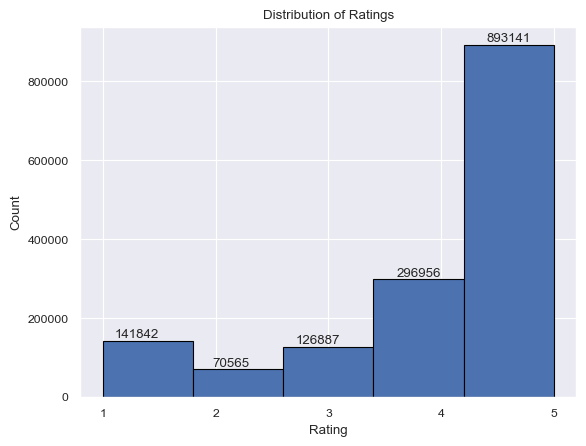

In [50]:
# Distribution of ratings: To understand the overall sentiment towards the businesses.

plt.hist(df['rating'], bins = 5, edgecolor = 'black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# show exact counts
for i in range(1, 6):
    plt.text(i + 0.5 if i == 1 else i + 0.3 if i == 2 else i + 0.1 if i == 3 else i if i == 4 else i - 0.2, len(df[df['rating'] == i]), str(len(df[df['rating'] == i])), ha='right', va='bottom')
# change x ticks to read 1, 2, 3, 4, 5
plt.xticks(np.arange(1, 6, 1))

plt.show()


## Exploring review counts per local business

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Most businesses have 0-200 reviews, with the number of businesses decreasing at a decreasing rate as the number of reviews increases.
* This suggests that a small number of businesses might be overrepresented in our dataset, especially the one outlying businesses with 2000+ reviews.

Summary statistics for count of reviews per business:
count    9568.000000
mean      159.844377
std       172.577567
min         1.000000
25%        55.000000
50%       109.000000
75%       206.000000
max      2831.000000
Name: count, dtype: float64


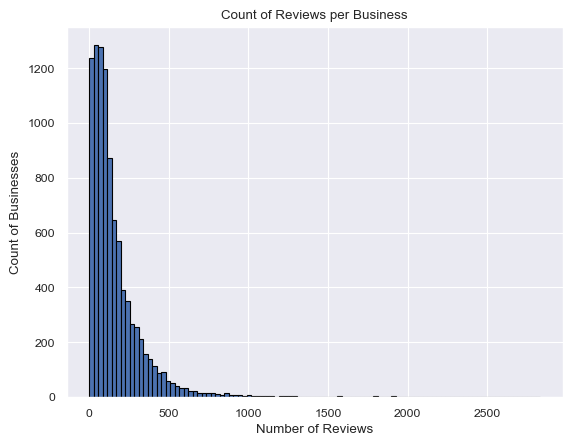

In [51]:
# Count of reviews per business - To see which businesses have been reviewed the most.

# describe the count of reviews per business
print("Summary statistics for count of reviews per business:")
print(df['gmap_id'].value_counts().describe())

df['gmap_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Reviews per Business')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Businesses')
plt.show()




## Exploring review lengths (in terms of number of characters)

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that review lengths are distributed similarly to business ratings, with a large number of reviews having under 200 characters, and with the number of reviews decreasing at a decreasing rate as the review length increases.

In [52]:
df['text'] 
# drop floats - there are only 12 of them, probably just anomalies
df = df.drop(df[df['text'].apply(type) == float].index)

Summary statistics for review length:
count    1.529379e+06
mean     1.320390e+02
std      1.923557e+02
min      1.000000e+00
25%      3.200000e+01
50%      6.900000e+01
75%      1.550000e+02
max      8.973000e+03
Name: review_length, dtype: float64


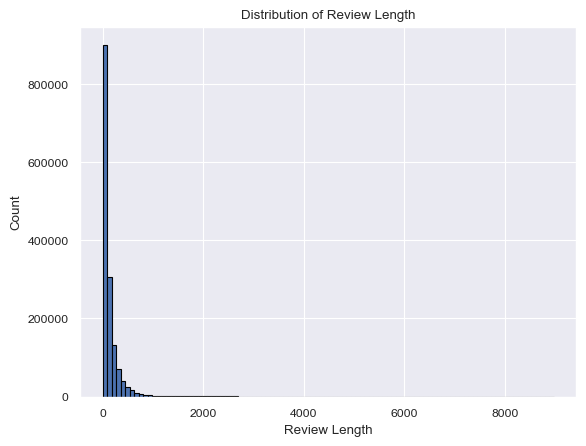

In [53]:
# Review length analysis: To see the distribution of the length of the review texts.

df['review_length'] = df['text'].apply(lambda x: len(x) if x is not None else 0)

# describe the review length
print("Summary statistics for review length:")
print(df['review_length'].describe())

plt.hist(df['review_length'], bins=100, edgecolor='black')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()



## Exploring correlation between review length and rating

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We analyzed the correlation between the length of the review text and the rating. The correlation coefficient is around -0.25, which suggests that there is only a weak negative correlation between the length of the review and the rating.
* This result is consistent with our intuition, as the length of a review does not necessarily indicate its quality or sentiment.
* However, perhaps some angrier customers might leave longer reviews, which could explain the slight negative correlation. 

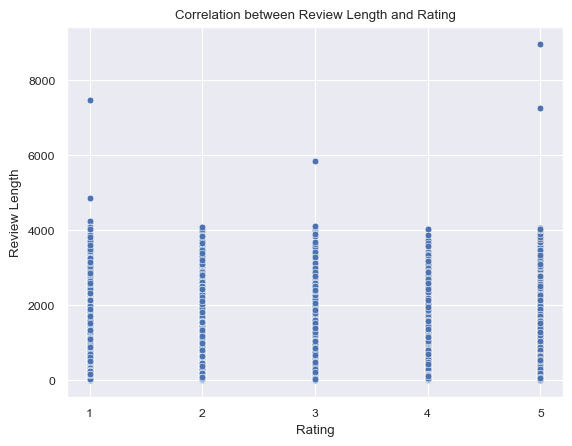

Correlation matrix:
                 rating  review_length
rating         1.000000      -0.252951
review_length -0.252951       1.000000


In [54]:
# Correlation between review length and rating: To see if there is a correlation between the length of the review and the rating given.

# plot the correlation between review length and rating
sns.scatterplot(x='rating', y='review_length', data=df)
plt.title('Correlation between Review Length and Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.xticks(np.arange(1, 6, 1))
plt.show()

correlation_matrix = df[['rating', 'review_length']].corr()
print("Correlation matrix:")
print(correlation_matrix)

## Number of unique authors

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We believe most authors only leave 1-5 reviews. This is confirmed by the mean number of reviews per author, which is around 4.87.
* In fact, we see through the summary statistics that over 75% of authors have only left 2 reviews or less. 
* The shape of the distribution is once again similar to the previous two, with the number of authors decreasing at a decreasing rate as the number of reviews per author increases.

Number of unique authors:  612146
Summary statistics for number of ratings per author:
count    612146.000000
mean          2.498389
std           4.292764
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         239.000000
Name: count, dtype: float64


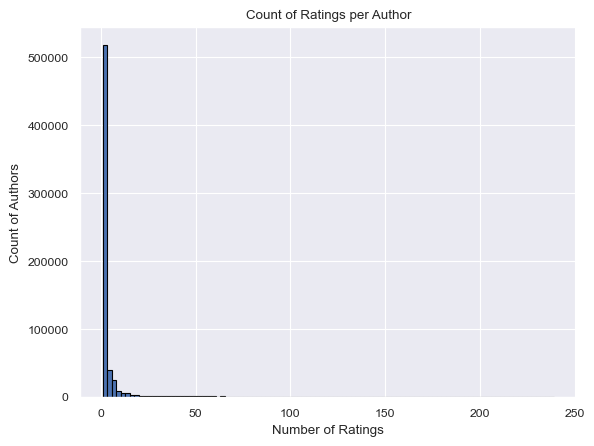

In [55]:
# How many unique authors?

print("Number of unique authors: ", df['user_id'].nunique())

# describe the count of ratings per author
print("Summary statistics for number of ratings per author:")
print(df['user_id'].value_counts().describe())

df['user_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Ratings per Author')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Authors')
plt.show()


## Simple sentiment analysis - Baseline Model

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We used the `TextBlob` library to perform a simple sentiment analysis on the review text.
* First, we dropped reviews with no text, as they would not provide any information for sentiment analysis.
* We then calculated the polarity of each review, which ranges from -1 (most negative) to 1 (most positive).
* Plotting a histogram and summary statistics, we see that most reviews are moderately positive with a mean polarity of 0.36 and a standard deviation of 0.31. This is consistent with our earlier observation that most ratings are positive (5 stars).
* The distribution is roughly bell-shaped, but with a density spike at 0 and a few more spikes above 0.5. 


Summary statistics for sentiment:
count    1.529379e+06
mean     4.036130e-01
std      3.707949e-01
min     -1.000000e+00
25%      1.666667e-01
50%      4.367187e-01
75%      6.916667e-01
max      1.000000e+00
Name: sentiment, dtype: float64


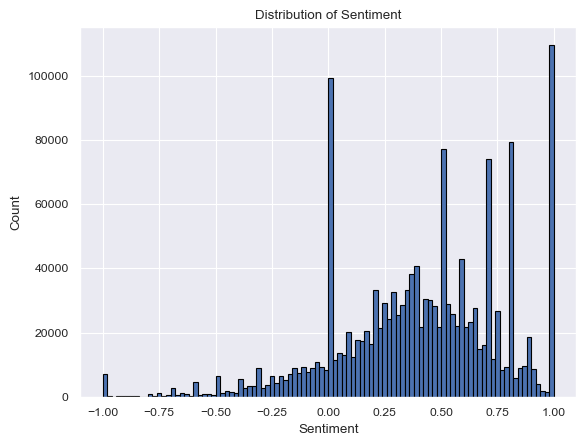

In [56]:
# Simple sentiment analysis on review text

# Add a column to the dataframe with the sentiment of the review
df_dropped = df.dropna(subset=['text'])
df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# print summary statistics
print("Summary statistics for sentiment:")
print(df_dropped['sentiment'].describe())

# plot the distribution of sentiment
plt.hist(df_dropped['sentiment'], bins=100, edgecolor='black')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

There is a moderate positive correlation between sentiment score and rating, with a correlation coefficient of 0.547. This suggests that reviews with higher ratings tend to have more positive sentiment scores, which is expected. This is a good result for our training data.

We were worried that meaningful sentiment might not be extracted from short reviews, but the correlation suggests that the sentiment analysis is capturing the sentiment of the reviews decently well. Yay!

In [57]:
# Find correlation between sentiment and rating
correlation_matrix = df_dropped[['rating', 'sentiment']].corr()
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
             rating  sentiment
rating     1.000000   0.600953
sentiment  0.600953   1.000000


## Summary of findings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that the majority of ratings given by Google users are 5 out of 5. This aligns with the Google text review sentiment analysis, which found that the majority of the reviews had a postive sentiment.
* We also found that there is a weak correlation between the length of a text review and the rating given by the same Google user. However, it could be helpful to note that based on the visualization displayed above, the review length was longest for either 1 or 5 star reviews.
* In the sentiment analysis, we found that majority of the text reviews result in a sentiment score near 0, which suggests that many reviews are neutral. The second most common sentiment scores are those near 1, which suggests that there are also many (but not as many) reviews that are highly positive. 
* This summarizes the distributional features of our reviews in their length, sentiment and the related score.

## Revised Project Question

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Creating a restaurant recommendation system based on textual reviews and and user-inputted prompts.


## Implementation Plan -- Draft Pipeline

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The structure of our problem is similar to that of designing a recommender system. We describe an initial approach that comes to mind:

**Recommender Model Pipeline:**
- **Training step** (preprocessing): Embed the reviews for all restaurants as vectors using sentence embeddings (BERT), or a combined approach using BERT and other feature engineered features from the restaurant information that we have. One approach is then to cluster restaurants in an unsupervised way in the feature space using an approach like KNN or t-SNE. Perhaps we can do this in an informed way, however.
- **Interaction step:** Then, we may take a user prompt of sentence length describing the restaurant type they are looking for, and use the fine-tuned BERT pipeline to get a vector representation of the prompt.
- **Matching step:** Then we can take the top recommendations as the closest three or so restaurants in the feature space to the prompt. We can incorporate additional heuristics in this matching step.
  

**Potential Issues:**
- Reviews and prompts are semantically different. We might encounter unexpected relationships between the restaurants closest in the feature space based on reviews and the inputted prompts.
- Perhaps a content-based filtering approach is more directly applicable as a pipeline (ref: https://developers.google.com/machine-learning/recommendation/content-based/basics).
- With an unsupervised approach like this, we have no systematized way to measure whether our recommending algorithm is doing a good job at matching prompts to restaurants. But this is the nature of trying a recommendation system rather than a predictive model. We do not have the resources to conduct proper A/B testing, which would otherwise be a canonical solution.
-  A collaborative filtering approach would be great, but is infeasible since we cannot recruit enough users. 

# 3. Pipeline and Baseline Model:

#### preprocessing:

In [60]:
df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [61]:
df.head()

,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,Dining options,Popular for,Atmosphere,Crowd
48,108514047127289837883,5.0,Amazing food and T is an amazing man.,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"['Pizza restaurant', 'Italian restaurant', 'De...",3.9,48.0,2,"[['Thursday', '11AM–8PM'], ['Friday', '11AM–10...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Breakfast', 'Lunch', 'Dinner', 'Solo dining']","['Casual', 'Cozy']",any
50,100299238448263786400,3.0,I didn't actually try it but just felt like gi...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"['Pizza restaurant', 'Italian restaurant', 'De...",3.9,48.0,2,"[['Thursday', '11AM–8PM'], ['Friday', '11AM–10...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Breakfast', 'Lunch', 'Dinner', 'Solo dining']","['Casual', 'Cozy']",any
52,117632307472691068998,5.0,I am a huge fan of their sandwiches! Made to o...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"['Pizza restaurant', 'Italian restaurant', 'De...",3.9,48.0,2,"[['Thursday', '11AM–8PM'], ['Friday', '11AM–10...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Breakfast', 'Lunch', 'Dinner', 'Solo dining']","['Casual', 'Cozy']",any
54,100627839291727776043,2.0,There's a reason why it's not called 5 star pi...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"['Pizza restaurant', 'Italian restaurant', 'De...",3.9,48.0,2,"[['Thursday', '11AM–8PM'], ['Friday', '11AM–10...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Breakfast', 'Lunch', 'Dinner', 'Solo dining']","['Casual', 'Cozy']",any
56,113843275698867858889,4.0,Drunk and starving at 1am? They're open!,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"['Pizza restaurant', 'Italian restaurant', 'De...",3.9,48.0,2,"[['Thursday', '11AM–8PM'], ['Friday', '11AM–10...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Breakfast', 'Lunch', 'Dinner', 'Solo dining']","['Casual', 'Cozy']",any


In [62]:
### get 10000 restaurants dumb sample. Take pics out.

# Import the necessary libraries
# Set the random seed for reproducibility
np.random.seed(42)

# Group by 'name_y'
grouped = df.groupby('name_y')


# If you need to work with all entries for each 'gmap_id' and then select 1000 groups
## Option 1: Select the first 1000 unique restaurants
top_1000_restaurants = grouped.apply(lambda x: x.head(1)).sample(1000)

## Option 2: If you need to select based on the size of each group (e.g., most entries)
# This will sort groups by size and take the top 1000 groups
top_1000_restaurants = grouped.size().nlargest(500).index
selected_entries = df[df['name_y'].isin(top_1000_restaurants)]


## Option 3:
# Randomly sample 1000 unique restaurants
# Ensure you have unique restaurants first
unique_restaurants = df.drop_duplicates(subset='name_y')
n_0 = 100
if len(unique_restaurants) >= n_0:
    sampled_restaurants = unique_restaurants.sample(n=n_0, random_state=1)  # Use random_state for reproducibility
else:
    print("There are less than 1000 unique restaurants available.")
    sampled_restaurants = unique_restaurants  # Use all available if less than 1000

# Now, get all entries for these 1000 restaurants
selected_entries = df[df['name_y'].isin(sampled_restaurants['name_y'])]

# Print or inspect the result
display(selected_entries)

# we have 76k rows. This is workable.
df = selected_entries
# Preprocess to remove invalid coordinate restaurants
df = df[(df['latitude'] != 0) | (df['longitude'] != 0)]

,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,Dining options,Popular for,Atmosphere,Crowd
24239,118113880102486083012,3.0,"I generally like D'Angelo, but this location i...",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly']
24240,108362265447601500205,1.0,I'm going to be honest I worked with them D'An...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly']
24241,103812894472086758890,1.0,I just got a sub at this D'Angelo's and it was...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly']
24242,106069444422440760065,2.0,Why say you deliver whenever I call for a deli...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly']
24243,110235543506695192405,1.0,Terribly made subs I was pissed all week for ...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081966,108578748495275402401,3.0,I like the beer here.,0x89e729f45f890801:0x106e034a60f569b7,The Brewmaster's Tavern,42.392438,-72.730503,"['American restaurant', 'Bar']",4.1,507.0,2,"[['Sunday', '9AM–9PM'], ['Monday', '11AM–9PM']...","['Breakfast', 'Lunch', 'Dinner', 'Catering', '...","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['College students', 'Family-friendly', 'Group..."
4081967,109104843826674616025,4.0,Great food and service,0x89e729f45f890801:0x106e034a60f569b7,The Brewmaster's Tavern,42.392438,-72.730503,"['American restaurant', 'Bar']",4.1,507.0,2,"[['Sunday', '9AM–9PM'], ['Monday', '11AM–9PM']...","['Breakfast', 'Lunch', 'Dinner', 'Catering', '...","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['College students', 'Family-friendly', 'Group..."
4081968,104333495627639362021,5.0,"Love this place, hot staff",0x89e729f45f890801:0x106e034a60f569b7,The Brewmaster's Tavern,42.392438,-72.730503,"['American restaurant', 'Bar']",4.1,507.0,2,"[['Sunday', '9AM–9PM'], ['Monday', '11AM–9PM']...","['Breakfast', 'Lunch', 'Dinner', 'Catering', '...","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['College students', 'Family-friendly', 'Group..."
4081969,117318101400422737775,5.0,(Translated by Google) Everything tastes reall...,0x89e729f45f890801:0x106e034a60f569b7,The Brewmaster's Tavern,42.392438,-72.730503,"['American restaurant', 'Bar']",4.1,507.0,2,"[['Sunday', '9AM–9PM'], ['Monday', '11AM–9PM']...","['Breakfast', 'Lunch', 'Dinner', 'Catering', '...","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['College students', 'Family-friendly', 'Group..."


### Stage 1: filter by basic criteria

In [63]:
# !pip install geocoder
# !pip install geopy

In [64]:
import geocoder
import pandas as pd
from geopy.distance import geodesic

# Get user coordinates
def get_user_coordinates():
    g = geocoder.ip('me')
    if g.latlng:
        return g.latlng
    else:
        return None

coordinates = get_user_coordinates()
if coordinates:
    user_latitude, user_longitude = coordinates
    print(f"User's coordinates: Latitude={user_latitude}, Longitude={user_longitude}")
else:
    print("Unable to retrieve user's coordinates.")
    # Define default values or handle lack of coordinates appropriately
    # user_latitude, user_longitude = default_latitude, default_longitude


# Function to calculate distance using geopy
def calculate_distance(row, user_lat, user_lon):
    user_location = (user_lat, user_lon)
    business_location = (row['latitude'], row['longitude'])
    return geodesic(user_location, business_location).miles

# Apply the distance function
df['distance'] = df.apply(lambda row: calculate_distance(row, user_latitude, user_longitude), axis=1)
df_filtered = df[df['distance'] <= 10]  # Filter data within 10 miles

# Print the filtered DataFrame
print(df_filtered)


User's coordinates: Latitude=42.3751, Longitude=-71.1056
                       user_id  rating  \
24239    118113880102486083012     3.0   
24240    108362265447601500205     1.0   
24241    103812894472086758890     1.0   
24242    106069444422440760065     2.0   
24243    110235543506695192405     1.0   
...                        ...     ...   
3989958  117820342947963981694     4.0   
3989959  114523242175910611929     5.0   
3989960  102380164715308354113     5.0   
3989961  114731935687817810748     5.0   
3989962  110385607030726952399     4.0   

                                                      text  \
24239    I generally like D'Angelo, but this location i...   
24240    I'm going to be honest I worked with them D'An...   
24241    I just got a sub at this D'Angelo's and it was...   
24242    Why say you deliver whenever I call for a deli...   
24243    Terribly made subs I  was pissed all week for ...   
...                                                    ...   
3989

In [65]:
df_filtered

,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,Dining options,Popular for,Atmosphere,Crowd,distance
24239,118113880102486083012,3.0,"I generally like D'Angelo, but this location i...",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
24240,108362265447601500205,1.0,I'm going to be honest I worked with them D'An...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
24241,103812894472086758890,1.0,I just got a sub at this D'Angelo's and it was...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
24242,106069444422440760065,2.0,Why say you deliver whenever I call for a deli...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
24243,110235543506695192405,1.0,Terribly made subs I was pissed all week for ...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.330980,-71.053190,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989958,117820342947963981694,4.0,Try the shift drink and have some oysters!,0x89e379f5fc7c5a4f:0x3a608fcad04c37f3,Citizen Public House & Oyster Bar,42.344233,-71.098032,"['Restaurant', 'Bar', 'Seafood restaurant']",4.3,595.0,2,"[['Monday', '5–11PM'], ['Tuesday', '5–11PM'], ...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['Family-friendly', 'Groups']",2.165427
3989959,114523242175910611929,5.0,Sunday brunch is excellent.,0x89e379f5fc7c5a4f:0x3a608fcad04c37f3,Citizen Public House & Oyster Bar,42.344233,-71.098032,"['Restaurant', 'Bar', 'Seafood restaurant']",4.3,595.0,2,"[['Monday', '5–11PM'], ['Tuesday', '5–11PM'], ...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['Family-friendly', 'Groups']",2.165427
3989960,102380164715308354113,5.0,Great selection of whiskeys.,0x89e379f5fc7c5a4f:0x3a608fcad04c37f3,Citizen Public House & Oyster Bar,42.344233,-71.098032,"['Restaurant', 'Bar', 'Seafood restaurant']",4.3,595.0,2,"[['Monday', '5–11PM'], ['Tuesday', '5–11PM'], ...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['Family-friendly', 'Groups']",2.165427
3989961,114731935687817810748,5.0,(Translated by Google) A pub near Feway Park. ...,0x89e379f5fc7c5a4f:0x3a608fcad04c37f3,Citizen Public House & Oyster Bar,42.344233,-71.098032,"['Restaurant', 'Bar', 'Seafood restaurant']",4.3,595.0,2,"[['Monday', '5–11PM'], ['Tuesday', '5–11PM'], ...","['Breakfast', 'Lunch', 'Dinner', 'Dessert']","['Lunch', 'Dinner', 'Solo dining']",['Casual'],"['Family-friendly', 'Groups']",2.165427


In [67]:
# inspect hours column
# df reset index
df.reset_index(drop=True, inplace=True)
df.head(10)
df.head(10)




,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,Dining options,Popular for,Atmosphere,Crowd,distance
0,118113880102486083012,3.0,"I generally like D'Angelo, but this location i...",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
1,108362265447601500205,1.0,I'm going to be honest I worked with them D'An...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
2,103812894472086758890,1.0,I just got a sub at this D'Angelo's and it was...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
3,106069444422440760065,2.0,Why say you deliver whenever I call for a deli...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
4,110235543506695192405,1.0,Terribly made subs I was pissed all week for ...,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
5,117951083715083275781,5.0,"Great food, great bread, good prices around th...",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
6,105382614716775596978,4.0,"Food great, staff cool people",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
7,108672704654847731935,3.0,"Not a terrible option, but could very better",0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
8,118419427590073270934,4.0,The new burgers are great,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.058681
9,112943319237093876754,4.0,Great views!,0x89e37a5e4917e8fd:0xd016270535d33428,D'Angelo Grilled Sandwiches,42.33098,-71.05319,"['Sandwich shop', 'Deli', 'Fast food restauran...",3.4,18.0,1,"[['Tuesday', '10AM–8PM'], ['Wednesday', '10AM–...","['Dinner', 'Catering', 'Dessert', 'Seating']","['Dinner', 'Solo dining']",['Casual'],['Family-friendly'],4.0

In [ ]:
### filter by opening hour -- DHATI

import pandas as pd
from datetime import datetime
import pytz 
from dateutil import parser



def is_open(current_time, hours_str):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    current_day = days[current_time.weekday()]
    for day_segment in eval(hours_str):
        day, hours = day_segment[0], day_segment[1]
        print(day, hours)
        print(hours.split('–'))
        if day == current_day and hours != 'Closed':
            open_time, close_time = hours.split('–')
            open_time = parser.parse(open_time).time()
            close_time = parser.parse(close_time).time()
            if current_time.time() >= open_time and current_time.time() <= close_time:
                return True
    return False

user_timezone = pytz.timezone('America/New_York') 
current_time = datetime.now(user_timezone)

# Apply the function to filter DataFrame
df['is_open'] = df['hours'].apply(lambda x: is_open(current_time, x) if pd.notna(x) else False)


df_open_now = df[df['is_open']]


df_open_now

In [ ]:
### lookup dish: DHATI, JANICE

# get dish from user as a prompt

import pandas as pd
import re

# Function to create a regex pattern for the dish to handle variations
def create_dish_pattern(dish_name):
    words = dish_name.split()
    if len(words) > 1:
        # Create patterns to match both possible word orders
        pattern1 = r'\b' + r'\b.*\b'.join(map(re.escape, words)) + r'\b'
        pattern2 = r'\b' + r'\b.*\b'.join(map(re.escape, reversed(words))) + r'\b'
        return re.compile(pattern1 + '|' + pattern2, re.IGNORECASE)
    else:
        return re.compile(r'\b' + re.escape(dish_name) + r'\b', re.IGNORECASE)

# Function to find reviews that mention the dish using the regex pattern
def find_dish_reviews(df, pattern):
    matches = df['text'].str.contains(pattern, na=False)
    return df[matches]

# Get dish name from user
dish_name = input("Enter the name of the dish you are looking for: ")
pattern = create_dish_pattern(dish_name)

# Find reviews mentioning the dish
dish_reviews = find_dish_reviews(df, pattern)


print(dish_reviews[['name_y', 'text']])

# go restaurant by restaurant, then dish by dish, and look all reviews that mention prompt (my best guess is use regex, but think intelligently. pasta alfredo vs alfredo pasta)

### Stage 2: rank by sentiment for the dish - SUSANNAH, ETHAN.

In [ ]:
# quick recap of the output from stage 1
dish_reviews.head()

In [ ]:
dish_reviews.describe()

In [ ]:
# NEW STUFF HERE (May 6th)

To rank restaurants based on the sentiment of specific dish reviews and considering the sentiment in a contextual manner, we'll need to perform sentiment analysis on the text of the reviews that mention the dish.

To perform more nuanced and contextually aware insights, we chose to use transformer. We chose the pre-trained model `distilbert-base-uncased-finetuned-sst-2-english` because it is fine-tuned on a relevant task (Stanford Sentiment Treebank version 2, SST-2) and performs well on English text.

The model has a maximum sequence length (512 tokens) that it can handle. To be intelligent about this limitation, since we care about the sentiment of that dish, we decide to focus on the part of the review text that surrounds the name of the dish within a window of about 512 tokens.

In [ ]:
from transformers import pipeline
from transformers import DistilBertTokenizer

In [ ]:
# load a pre-trained model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analysis = pipeline("sentiment-analysis", model=model_name)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [ ]:
def basic_model_sentiment(text):
    # Tokenize the text and truncate if it exceeds the maximum length
    tokens = tokenizer.tokenize(text)[:512]  # Explicit truncation
    # Convert tokens back to string for sentiment analysis
    focused_text = tokenizer.convert_tokens_to_string(tokens)
    # Perform sentiment analysis
    result = sentiment_analysis(focused_text)
    # Calculate score, considering the label
    score = result[0]['score']
    if result[0]['label'] == 'NEGATIVE':
        score = -score
    return score

# Apply the sentiment analysis function to each review
dish_reviews['sentiment_score'] = dish_reviews['text'].apply(basic_model_sentiment)


In [ ]:
# BELOW ARE OLD STUFF (May 6th)

In [ ]:
from textblob import TextBlob

In [ ]:
df.head()

In [ ]:
# Do a general, simple sentiment analysis on the reviews first
def analyze_general_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [ ]:
df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['text'].apply(analyze_general_sentiment))

In [ ]:
df[['sentiment_polarity', 'sentiment_subjectivity']].describe()

**Sentiment Polarity**
* Definition: Sentiment polarity is a floating-point number ranging between -1.0 and 1.0. This score represents the emotional leaning of the text, where -1.0 signifies extreme negativity, 1.0 signifies extreme positivity, and 0 signifies neutrality.
* Interpretation:
    * Negative polarity (less than 0): Indicates negative sentiments in the text.
    * Positive polarity (greater than 0): Indicates positive sentiments in the text.
    * Zero polarity: Indicates neutral sentiments in the text.
 
**Sentiment Subjectivity**
* Definition: Sentiment subjectivity ranges between 0 and 1. This score reflects how much of the text is based on personal opinions, emotions, or judgments rather than factual information.
* Interpretation:
    * Subjectivity close to 0: Texts are more objective, likely based on factual information.
    * Subjectivity close to 1: Texts are more subjective, heavily influenced by personal feelings or opinions.

**Interpretation of our data**

* The mean polarity of 0.4289 suggests that, on average, the reviews lean towards being more positive.
* The minimum value at -1.0 and maximum at 1.0 indicate that there are both extremely negative and extremely positive reviews in the dataset.

* The mean subjectivity of 0.6135 indicates that the reviews, on average, are somewhat subjective and likely to contain personal opinions rather than solely factual descriptions.
* The standard deviation for subjectivity (0.2214) suggests there's some variation in how subjective the reviews are, with some being more fact-based and others more opinion-oriented.

In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def get_weighted_index(row):
    sentiment = get_sentiment(row['text'])
    avg_rating = row['rating']
    return 0.8 * sentiment + 0.2 * avg_rating

def get_top_restaurants(df, n):
    df['weighted_index'] = df.apply(get_weighted_index, axis=1)
    return df.sort_values('weighted_index', ascending=False).head(n)

get_top_restaurants(df, 10)

#### Combine all the above functions into a pipeline

In [ ]:
def get_recommendations(df, dish_name, n):
    df_open_now = df[df['is_open']]
    pattern = create_dish_pattern(dish_name)
    dish_reviews = find_dish_reviews(df_open_now, pattern)
    return get_top_restaurants(dish_reviews, n)

dish_name = "pasta"
n = 10

get_recommendations(df, dish_name, n)
